In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmyt
import archives_manager

pd.set_option('display.max_rows', None)
pd.set_option('display.width', 10000)

In [2]:
player_name = "BIG_TONKA_T"
start_unix = 1696176000
end_unix = 1698768000

game_archive = archives_manager.get_games_between_timestamps(player_name, start_unix, end_unix, time_class='rapid', filter_func=archives_manager.build_archive_filter(
    rated=True
))

archives_manager.simplified_archived_game(game_archive[0])

{'url': 'https://www.chess.com/game/live/89923795267',
 'end_time': 1696185098,
 'date': '2023.10.01',
 'rated': True,
 'time_class': 'rapid',
 'white': {'username': 'Quarini', 'rating': 1064, 'result': 'resigned'},
 'black': {'username': 'BIG_TONKA_T', 'rating': 1089, 'result': 'win'}}

In [3]:
archives_manager.simplified_archived_game(game_archive[-1])

{'url': 'https://www.chess.com/game/live/92035707081',
 'end_time': 1698296732,
 'date': '2023.10.26',
 'rated': True,
 'time_class': 'rapid',
 'white': {'username': 'Primodiurno', 'rating': 1456, 'result': 'resigned'},
 'black': {'username': 'BIG_TONKA_T', 'rating': 1494, 'result': 'win'}}

In [4]:
import chess
from chess import pgn
from chess import Board

In [5]:
import board_feature_extractor
import io

In [6]:

def check_status(board):
    """
    Check the status of the kings in the given chess board.

    Args:
    board (chess.Board): A chess board.

    Returns:
    int: 0 if no king is in check, 1 if black king is in check, -1 if white king is in check.
    """
    if board.is_check():
        if board.turn == chess.WHITE:
            # Black king is in check
            return 1
        else:
            # White king is in check
            return -1
    else:
        # No king is in check
        return 0


def material_count(board):
    """
    Calculate the material count in points for white and black pieces on the board.

    Args:
    board (chess.Board): A chess board.

    Returns:
    dict: A dictionary with 'white' and 'black' keys and their respective material points as values.
    """
    # Define the point values for each piece type
    piece_values = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 5,
        chess.QUEEN: 9
    }

    # Initialize counts
    white_material = 0
    black_material = 0

    # Iterate over all squares
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            # Add the value to the respective side's material count
            value = piece_values.get(piece.piece_type, 0)
            if piece.color == chess.WHITE:
                white_material += value
            else:
                black_material += value

    return {'white': white_material, 'black': black_material}

def count_pieces(board):
    """
    Count the number of knights, bishops, rooks, and queens for each color.

    Args:
    board (chess.Board): A chess board.

    Returns:
    dict: A dictionary with counts of each piece type for white and black.
    """
    # Initialize counts
    counts = {
        'knights': {'white': 0, 'black': 0},
        'bishops': {'white': 0, 'black': 0},
        'rooks': {'white': 0, 'black': 0},
        'queens': {'white': 0, 'black': 0},
    }

    # Iterate over all squares
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            color = 'white' if piece.color == chess.WHITE else 'black'
            if piece.piece_type == chess.KNIGHT:
                counts['knights'][color] += 1
            elif piece.piece_type == chess.BISHOP:
                counts['bishops'][color] += 1
            elif piece.piece_type == chess.ROOK:
                counts['rooks'][color] += 1
            elif piece.piece_type == chess.QUEEN:
                counts['queens'][color] += 1

    return counts

def count_fully_developed_knights(board):
    """
    Count the number of fully developed knights for each color.

    Args:
    board (chess.Board): A chess board.

    Returns:
    dict: A dictionary with counts of fully developed knights for white and black.
    """
    # Initialize counts
    developed_knights = {'white': 0, 'black': 0}

    # Define valid files and ranks for fully developed knights
    valid_files = [2, 3, 4, 5]
    white_valid_ranks = range(3, 8) # rank 4 to rank 8
    black_valid_ranks = range(0, 5) # rank 1 to rank 5

    # Iterate over all squares with knights and check their positions
    for square in board.pieces(chess.KNIGHT, chess.WHITE):
        if chess.square_file(square) in valid_files and chess.square_rank(square) in white_valid_ranks:
            developed_knights['white'] += 1

    for square in board.pieces(chess.KNIGHT, chess.BLACK):
        if chess.square_file(square) in valid_files and chess.square_rank(square) in black_valid_ranks:
            developed_knights['black'] += 1

    return developed_knights

def count_pigs(board):
    """
    Count the number of 'pigs' (rooks deep in enemy territory) for each color.

    Args:
    board (chess.Board): A chess board.

    Returns:
    dict: A dictionary with counts of pigs for white and black.
    """
    # Initialize counts
    pigs = {'white': 0, 'black': 0}

    # Define valid ranks for pigs
    white_pig_ranks = [6, 7]  # ranks 7 and 8 for white
    black_pig_ranks = [0, 1]  # ranks 1 and 2 for black

    # Iterate over all squares with rooks and check their positions
    for square in board.pieces(chess.ROOK, chess.WHITE):
        if chess.square_rank(square) in white_pig_ranks:
            pigs['white'] += 1

    for square in board.pieces(chess.ROOK, chess.BLACK):
        if chess.square_rank(square) in black_pig_ranks:
            pigs['black'] += 1

    return pigs



In [61]:
board_features = []

for i in range(25):
    game = game_archive[i]
    board = Board()
    game_pgn = game['pgn']
    chess_game = pgn.read_game(io.StringIO(game_pgn))

    total_move_count = 0
    for move in chess_game.mainline_moves():
        total_move_count += 1

    move_count = 0

    for move in chess_game.mainline_moves():
        move_count += 1
        game_percentage = move_count / total_move_count

        pieces = board_feature_extractor.count_pieces(board)
        developed_pieces = board_feature_extractor.count_developed_pieces(board)
        open_files = board_feature_extractor.count_open_files(board)
        passed_pawns = board_feature_extractor.count_passed_pawns(board)
        materials = material_count(board)
        named_pieces = count_pieces(board)
        fully_developed_knights = count_fully_developed_knights(board)
        pigs = count_pigs(board)

        # pawn structure
        # https://chat.openai.com/share/12f03bd3-f950-4f0f-b563-494c9434b5f4
        # idea - simple approach
        # observe the pawn structure features for some games
        # 'norm_avg_col', 'norm_avg_row', 'num_pawns'
        # observe the pca of observations throughout some games, as black, as white, and combined
        # classify players by their average pawn structure lifetime (somehow)
        # classify opponents by the same metric
        # map winrate/accuracy_diff to classifications and observe

        board_features.append({
            'white_pieces': pieces['pieces']['white'],
            'black_pieces': pieces['pieces']['black'],
            'white_pawns': pieces['pawns']['white'],
            'black_pawns': pieces['pawns']['black'],
            'white_knights': named_pieces['knights']['white'],
            'black_knights': named_pieces['knights']['black'],
            'white_bishops': named_pieces['bishops']['white'],
            'black_bishops': named_pieces['bishops']['black'],
            'white_rooks': named_pieces['rooks']['white'],
            'black_rooks': named_pieces['rooks']['black'],
            'white_queens': named_pieces['queens']['white'],
            'black_queens': named_pieces['queens']['black'],
            'white_developed_pieces': developed_pieces['white'],
            'black_developed_pieces': developed_pieces['black'],
            'white_fully_developed_knights': fully_developed_knights['white'],
            'black_fully_developed_knights': fully_developed_knights['black'],
            'white_pigs': pigs['white'],
            'black_pigs': pigs['black'],
            'open_files': open_files,
            'white_passed_pawns': passed_pawns['white'],
            'black_passed_pawns': passed_pawns['black'],
            'check_status': check_status(board),
            'white_material': materials['white'],
            'black_material': materials['black'],
            'material_difference': materials['white'] - materials['black'],
            'white_castling_rights': int(board.has_castling_rights(chess.WHITE)),
            'black_castling_rights': int(board.has_castling_rights(chess.BLACK)),
            'game_percentage': game_percentage
        })

        board.push(move)

board_features_df = pd.DataFrame(board_features)
board_features_df.head()

,white_pieces,black_pieces,white_pawns,black_pawns,white_knights,black_knights,white_bishops,black_bishops,white_rooks,black_rooks,...,open_files,white_passed_pawns,black_passed_pawns,check_status,white_material,black_material,material_difference,white_castling_rights,black_castling_rights,game_percentage
0,7,7,8,8,2,2,2,2,2,2,...,0,0,0,0,39,39,0,1,1,0.021277
1,7,7,8,8,2,2,2,2,2,2,...,0,0,0,0,39,39,0,1,1,0.042553
2,7,7,8,8,2,2,2,2,2,2,...,0,0,0,0,39,39,0,1,1,0.063830
3,7,7,8,8,2,2,2,2,2,2,...,0,0,0,0,39,39,0,1,1,0.085106
4,7,7,8,8,2,2,2,2,2,2,...,0,0,0,0,39,39,0,1,1,0.106383


In [62]:
print(board_features_df.shape)
board_features_df.describe()

(1753, 28)


,white_pieces,black_pieces,white_pawns,black_pawns,white_knights,black_knights,white_bishops,black_bishops,white_rooks,black_rooks,...,open_files,white_passed_pawns,black_passed_pawns,check_status,white_material,black_material,material_difference,white_castling_rights,black_castling_rights,game_percentage
count,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,...,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000
mean,4.464347,4.584141,6.128922,6.084997,1.067313,1.096977,1.145465,1.165431,1.556189,1.623503,...,1.205933,0.217912,0.399886,-0.019395,26.806617,27.273816,-0.467199,0.297775,0.322305,0.507131
std,2.332276,2.204945,2.272888,2.034567,0.884951,0.847207,0.823425,0.811597,0.677726,0.663597,...,1.773192,0.502708,0.869538,0.286034,12.188105,11.519503,3.841194,0.457411,0.467492,0.288742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.006667
25%,2.000000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,15.000000,16.000000,-1.000000,0.000000,0.000000,0.258065
50%,5.000000,5.000000,7.000000,6.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,30.000000,31.000000,0.000000,0.000000,0.000000,0.506849
75%,7.000000,7.000000,8.000000,8.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,0.000000,0.000000,0.000000,39.000000,39.000000,0.000000,1.000000,1.000000,0.755319
max,7.000000,7.000000,8.000000,8.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,8.000000,3.000000,4.000000,1.000000,39.000000,39.000000,14.000000,1.000000,1.000000,1.000000


In [63]:
# copy the dataframe and make a standardized version for the features
board_features_df_standardized = board_features_df.drop(columns=['game_percentage'], inplace=False).copy()
board_features_df_standardized = (board_features_df_standardized - board_features_df_standardized.mean()) / board_features_df_standardized.std()
print(board_features_df_standardized.head())
print(board_features_df_standardized.describe())

   white_pieces  black_pieces  white_pawns  black_pawns  white_knights  black_knights  white_bishops  black_bishops  white_rooks  black_rooks  ...  black_pigs  open_files  white_passed_pawns  black_passed_pawns  check_status  white_material  black_material  material_difference  white_castling_rights  black_castling_rights
0      1.087201      1.095655     0.823216     0.941234       1.053942       1.065883       1.037781       1.028305     0.654853     0.567359  ...   -0.284443   -0.680091           -0.433476           -0.459883      0.067808        1.000433        1.017942             0.121629               1.535217                1.44964
1      1.087201      1.095655     0.823216     0.941234       1.053942       1.065883       1.037781       1.028305     0.654853     0.567359  ...   -0.284443   -0.680091           -0.433476           -0.459883      0.067808        1.000433        1.017942             0.121629               1.535217                1.44964
2      1.087201      1.09565

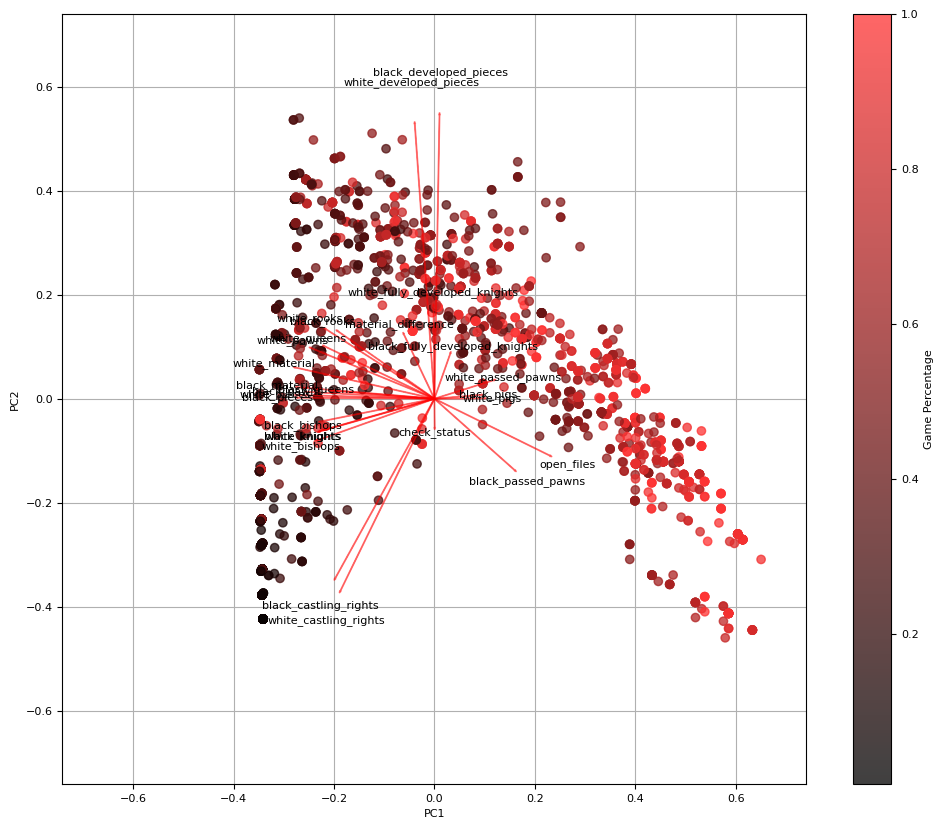

In [70]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from cmyt import pixel_red

# Assuming board_features_df_standardized is your standardized data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(board_features_df_standardized)

def pca_plot(score, coeff, feature_arrows=False, feature_labels=None, zoom=1,scatter_color='blue', scatter_cmap=None, scatter_color_label=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, c=scatter_color, cmap=scatter_cmap, alpha=0.75, zorder=4)
    if scatter_cmap:
        plt.colorbar(label=scatter_color_label)
    for i in range(n):
        if feature_arrows:
            plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5, zorder=5)
        if feature_labels is not None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, feature_labels[i], color = 'black', ha = 'center', va = 'center', zorder=6)
    plt.xlim(-1/zoom,1/zoom)
    plt.ylim(-1/zoom,1/zoom)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid(zorder=3)
    

#Call the function. Use only the 2 PCs.
plt.figure(figsize=(12, 10))
plt.rcParams.update({'font.size': 8})

pca_plot(
    pca_result[:,0:2],
    np.transpose(pca.components_[0:2, :]),
    feature_arrows=True,
    feature_labels=board_features_df_standardized.columns,
    zoom=1.35,
    scatter_color=board_features_df['game_percentage'],
    scatter_cmap=pixel_red,
    scatter_color_label='Game Percentage'
)
plt.show()


